# Abstract

Machine learning plays a pivotal role in pathology classification, offering a transformative approach to the analysis and interpretation of medical images. In the field of pathology, the accurate and efficient identification of diseases, tumors, and anomalies within tissue samples is essential for timely diagnosis and treatment. Machine learning models, particularly deep learning algorithms, have demonstrated their prowess in automating and enhancing the accuracy of pathological image analysis. By leveraging vast datasets and training models to recognize subtle patterns and features, these technologies aid pathologists in making quicker and more precise diagnoses. Moreover, they enable the identification of novel biomarkers and predictive factors, advancing our understanding of diseases and paving the way for personalized treatment strategies. The adoption of machine learning in pathology classification not only improves patient care but also optimizes workflows and augments the capabilities of healthcare professionals, showcasing its profound significance in modern healthcare.

**Objective**: Detect metastatic tumor patches from stained histopathology data using machine learning

# Libraries

In [1]:
# Libraries

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import h5py

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import random
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
import copy

font1 = {'family':'serif','color':'blue','size':15}
font2 = {'family':'serif','color':'darkred','size':15}
font3 = {'family':'serif','color':'darkgreen','size':30}

# Data Import and Visualization

In [2]:
# Functions

def LoadFile(file_path):
    """This algorithm loads a HDF5 file and returns its content."""
    with h5py.File(file_path, "r") as f:
        data = f[list(f.keys())[0]][:]
    return data

def SampleVisualization(images, labels, num_samples=5):
    """Visualize random image samples with their labels."""
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        if 0 in labels[idx]:
            plt.title(f"Healthy")
        else:
            plt.title(f"Metastatic")
        plt.axis("off")
    plt.tight_layout()

def DataCheck(images, labels):
    """Algorithm that checks the data properties"""

    image_shape = images.shape
    label_shape = labels.shape
    label_distribution = np.unique(labels, return_counts=True)
    
    if image_shape[0] != label_shape[0]:
        print(f"Not all images have corresponding label! There are {image_shape[0]} images and {label_shape[0]} labels!")
    else:
        print(f"There are {image_shape[0]} images in the dataset and all have corresponding labels!")

    if label_distribution[1][0] != label_distribution[1][1]:
        print(f"{np.round(label_distribution[1][0]/image_shape[0]*100,2)}% images show healthy tissue and {np.round(label_distribution[1][1]/image_shape[0]*100,2)}% images show metastatic tissue!")
    else:
        print("There is a equal distribution of healthy and metastatic tissue in the dataset!")

The data is stored in HDF5 files. The data is already divided into a training, a validation and test set:
- camelyonpatch_level_2_split_train_x.h5: Images of the training set
- camelyonpatch_level_2_split_train_y.h5: Labels of the training set
- camelyonpatch_level_2_split_valid_x.h5: Images of the validation set
- camelyonpatch_level_2_split_valid_y.h5: Labels of the validation set
- camelyonpatch_level_2_split_test_x.h5: Images of the test set
- camelyonpatch_level_2_split_test_y.h5: Labels of the test 

Images are considered to be metastatic if in the center 32x32 pixel region has at least one pixel tumour tissue present

In [ ]:
ratio = 100

# Loading the training set
train_images = LoadFile("Data/camelyonpatch_level_2_split_train_x.h5")
train_labels = LoadFile("Data/camelyonpatch_level_2_split_train_y.h5")

train_images = np.array_split(train_images, ratio)[0]
train_labels = np.array_split(train_labels, ratio)[0]

DataCheck(train_images, train_labels)

There are 2622 images in the dataset and all have corresponding labels!
46.91% images show healthy tissue and 53.09% images show metastatic tissue!


In [4]:
# Loading the validation set
val_images = LoadFile("Data/camelyonpatch_level_2_split_valid_x.h5")
val_labels = LoadFile("Data/camelyonpatch_level_2_split_valid_y.h5")

val_images = np.array_split(val_images, ratio)[0]
val_labels = np.array_split(val_labels, ratio)[0]


DataCheck(val_images, val_labels)

There are 328 images in the dataset and all have corresponding labels!
46.34% images show healthy tissue and 53.66% images show metastatic tissue!


In [5]:
# Loading the test set
test_images = LoadFile("Data/camelyonpatch_level_2_split_test_x.h5")
test_labels = LoadFile("Data/camelyonpatch_level_2_split_test_y.h5")

test_images = np.array_split(test_images, ratio)[0]
test_labels = np.array_split(test_labels, ratio)[0]

DataCheck(test_images, test_labels)

There are 328 images in the dataset and all have corresponding labels!
47.56% images show healthy tissue and 52.44% images show metastatic tissue!


In [6]:
# Checking the size of the images
print(f"The Images are {train_images[0].shape[:2][0]} x {train_images[0].shape[:2][1]} pixels")

The Images are 96 x 96 pixels


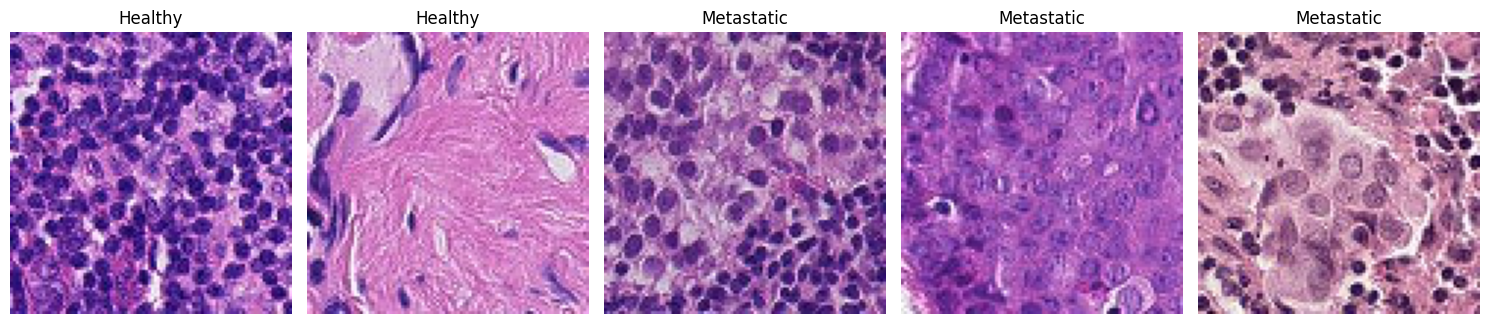

In [7]:
# Visualizing a few images of the training set
SampleVisualization(train_images, train_labels, num_samples=5)

In [8]:
# We check the shape of the labels
print("Train Labels Shape (Before):", train_labels.shape)

# Flatten the labels
train_labels = train_labels.ravel()
val_labels = val_labels.ravel()
test_labels = test_labels.ravel()

# Check the new shape
print("Train Labels Shape (After):", train_labels.shape)

Train Labels Shape (Before): (2622, 1, 1, 1)
Train Labels Shape (After): (2622,)


# Splitting the dataset

In [9]:
# Checking how the dataset is split.
total_data_number = train_images.shape[0] + val_images.shape[0] + test_images.shape[0]
print(f"There are in total {total_data_number} images in the whole dataset split into \n{train_images.shape[0]/total_data_number*100}% big training set"
      f"\n{val_images.shape[0]/total_data_number*100}% big validation set \n{test_images.shape[0]/total_data_number*100}% big test set")

There are in total 3278 images in the whole dataset split into 
79.98779743746186% big training set
10.006101281269068% big validation set 
10.006101281269068% big test set


As we can see above the dataset is already divided into a $80\%$ training, $10\%$ validation and $10\%$ test set. Therefore to redo this step would be redundant. 

In [10]:
# We also merge the training set and validation set for the 5 fold cross-validation
merged_training_images = np.concatenate((train_images, val_images))
merged_training_labels = np.concatenate((train_labels, val_labels))

# Classifier using PhyTorch

We will create our image classification using CNN (Convolutional Neural Network), which is a well established data architecture. It is a supervised machine learning methodology used mainly in image processing or speech recognition.

In [11]:
# Libraries
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn.functional as F


## Preprocessing

In [12]:
# Define mean and std for normalization
mean = [0.5, 0.5, 0.5]  # Placeholder, replace with actual dataset mean
std = [0.5, 0.5, 0.5]    # Placeholder, replace with actual dataset std

# Training data transformations (with augmentations)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),  # Rotate within 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(), # Transfroms PIL images to FloatTensors and scales the image's pixel intensity between tha range of [0,1]
    transforms.Normalize(mean, std)
])

# Validation and test data transformations (no augmentations)
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

In [13]:
# We create our custom dataset that will contain our data
class PCamDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return the lenght of the dataset
        return len(self.labels)
    
    def __getitem__(self, index):
        # Loads and returns a sample from the dataset at the given index
        image = self.images[index]
        label = self.labels[index]

        # Convert image to PIL for compatibility with transforms
        image = Image.fromarray(image)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label
    
# Creating the datasets
train_dataset = PCamDataset(train_images, train_labels, transform=train_transforms)
val_dataset = PCamDataset(val_images, val_labels, transform=val_test_transforms)
test_dataset = PCamDataset(test_images, test_labels, transform=val_test_transforms)
merged_traing_dataset = PCamDataset(merged_training_images, merged_training_labels, transform=val_test_transforms)

In [14]:
# While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.
# DataLoader is an iterable that abstracts this complexity for us in an easy API.
# Each iteration returns a bach of images and labels, as shuffle is specified as True, after an iteration over all batches the data is shuffled 

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
merged_loader = DataLoader(merged_traing_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check DataLoader
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2622
Validation dataset size: 328
Test dataset size: 328


In [15]:
# Cheking if the loaders can be loaded in to prevent the program being stuck
# Program stucking can occur if the num_workers > 0

for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Processing batch {batch_idx+1}/{len(train_loader)}")
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break  # Stop after the first batch

for batch_idx, (images, labels) in enumerate(val_loader):
    print(f"Processing batch {batch_idx+1}/{len(val_loader)}")
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break  # Stop after the first batch

for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"Processing batch {batch_idx+1}/{len(test_loader)}")
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break  # Stop after the first batch
for batch_idx, (images, labels) in enumerate(merged_loader):
    print(f"Processing batch {batch_idx+1}/{len(merged_loader)}")
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break  # Stop after the first batch

Processing batch 1/21
Batch size: torch.Size([128, 3, 96, 96]), Labels: torch.Size([128])
Processing batch 1/3
Batch size: torch.Size([128, 3, 96, 96]), Labels: torch.Size([128])
Processing batch 1/3
Batch size: torch.Size([128, 3, 96, 96]), Labels: torch.Size([128])
Processing batch 1/24
Batch size: torch.Size([128, 3, 96, 96]), Labels: torch.Size([128])


In [16]:
# Inspect one batch
for images, labels in train_loader:
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break

Batch size: torch.Size([128, 3, 96, 96]), Labels: torch.Size([128])


In [17]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [18]:
class PCamCNN(nn.Module):
    """The CNN module"""
    def __init__(self):
        super(PCamCNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 24 * 24, 256)  # Adjust input size based on pooling
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # Binary classification (Healthy vs. Metastatic)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten for Fully Connected Layers
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation (logits)
        
        return x

In [19]:
# Initialize the model
model = PCamCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class or binary classification with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Move model to GPU if available
# Assuming model, criterion, and optimizer are already defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send model to device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Assuming it's a binary classification problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop

def KfoldCrossValidation(dataset, criterion, optimizer_class, k=5, batch_size=64, num_epochs=10, learning_rate=0.001):
    kf = KFold(n_splits=k, shuffle=True)
    
    fold_accuracies = []
    fold_losses = []
    train_losses = []
    train_accuracies = []
    best_model = None
    best_val_accuracy = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"Training fold {fold + 1}/{k}...")
        
        # Create Subset datasets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        # Create DataLoader for this fold
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Initialize model for each fold
        model = PCamCNN().to(device)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate)

        # Call the train function for this fold
        fold_train_losses, fold_train_accuracies, fold_val_losses, fold_val_accuracies, val_accuracy = TrainModel(
            model, train_loader, val_loader, criterion, optimizer, num_epochs)

        fold_losses.append(fold_val_losses)
        fold_accuracies.append(fold_val_accuracies)
        train_losses.append(fold_train_losses)
        train_accuracies.append(fold_train_accuracies)

        # Update the best model if the current one is better
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model)

        print(f"Fold {fold + 1} completed.\n")

    # Calculate average performance over all folds
    avg_val_loss = np.mean(fold_losses)
    avg_val_accuracy = np.mean(fold_accuracies)
    
    print(f"Cross-Validation Results: Average Validation Loss: {avg_val_loss:.4f}, Average Validation Accuracy: {avg_val_accuracy:.2f}%")
    print(f"Best model selected with validation accuracy: {best_val_accuracy:.2f}%")

    return fold_accuracies, fold_losses, train_losses, train_accuracies, best_model


def TrainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """Trains the model on the training set"""
    
    train_losses = []  # Store training losses
    train_accuracies = []  # Store training accuracies
    val_losses = []  # Store validation losses
    val_accuracies = []  # Store validation accuracies
    
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)  # Move data to device
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)  # Get the predicted class (index of max output)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        val_loss, val_accuracy = EvaluateModel(model, val_loader, criterion)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
    return train_losses, train_accuracies, val_losses, val_accuracies, val_accuracy


def EvaluateModel(model, val_loader, criterion):
    """Evaluates the preformance of the trained model on the validation set"""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients required for validation
        for batch_idx, (images, labels) in enumerate(val_loader):
            #print(f"evalv batch {batch_idx+1}/{len(train_loader)}...")  # Debugging print
        #for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total
    
    return val_loss, val_accuracy

def TestModel(model, test_loader, criterion):
    """Evaluates the preformance of the trained model on the validation set"""
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    
    with torch.no_grad():  # No gradients required for validation
        for batch_idx, (images, labels) in enumerate(test_loader):
            #print(f"evalv batch {batch_idx+1}/{len(train_loader)}...")  # Debugging print
        #for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            predictions.append(predicted)
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total

    predictions = torch.cat(predictions, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    return predictions


def PlotTrainingCurves(train_losses, train_accuracies, val_losses, val_accuracies):
    """Plots the loss curves and accuracy curves of a training"""
    
    # Plot Loss curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

def PlotConfusionMatrix(cm):
    """Plots the confusion matrix"""
    
    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Metastatic'], yticklabels=['Healthy', 'Metastatic'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def PlotSamples(images, y_true, y_pred, title, indices):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img = images[idx]
        
        # Validate shape and ensure it is CHW
        if img.shape[0] == 96 and img.shape[1] == 96 and img.shape[2] == 3:
            img = img.transpose(2, 0, 1)  # Convert to CHW if in HWC format
        
        plt.subplot(4, 5, i + 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))  # Convert CHW -> HWC for plotting
        plt.axis('off')
    plt.suptitle(title, fontdict = font1)
    plt.show()

def CalculateMetrics(y_true, y_pred, images):
    """Calculates different metrics based on the predictions made on the test set"""
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"MCC: {mcc:.4f}")

    # plots the confustion matrix
    PlotConfusionMatrix(cm)

    # Get indices for true positives, false positives, true negatives, and false negatives
    tp_indices = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 1][:5]
    fp_indices = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 1][:5]
    tn_indices = [i for i in range(len(y_true)) if y_true[i] == 0 and y_pred[i] == 0][:5]
    fn_indices = [i for i in range(len(y_true)) if y_true[i] == 1 and y_pred[i] == 0][:5]

    # Plot samples for each category
    PlotSamples(images, y_true, y_pred, "Correctly Determined as Healthy", tp_indices)
    PlotSamples(images, y_true, y_pred, "Falsly Determined as Healthy", fp_indices)
    PlotSamples(images, y_true, y_pred, "Correctly Determined as Metastatic", tn_indices)
    PlotSamples(images, y_true, y_pred, "Falsly Determined as Metastatic", fn_indices)

In [21]:
# Set the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_class = optim.Adam  # Optimizer class (will be instantiated with model parameters)

# Start cross-validation
validation_accuracy, validation_losses, train_losses, train_accuracy, best_model = KfoldCrossValidation(train_dataset, criterion, optimizer_class, k=5, batch_size=batch_size, num_epochs=4)

Training fold 1/5...
Epoch 1/4, Train Loss: 0.7114, Train Accuracy: 51.98%, Val Loss: 0.6664, Val Accuracy: 52.00%
Epoch 2/4, Train Loss: 0.6459, Train Accuracy: 63.19%, Val Loss: 0.6598, Val Accuracy: 63.05%
Epoch 3/4, Train Loss: 0.6215, Train Accuracy: 67.81%, Val Loss: 0.5485, Val Accuracy: 65.33%
Epoch 4/4, Train Loss: 0.5847, Train Accuracy: 70.00%, Val Loss: 0.5143, Val Accuracy: 74.67%
Fold 1 completed.

Training fold 2/5...
Epoch 1/4, Train Loss: 0.6927, Train Accuracy: 58.46%, Val Loss: 0.6178, Val Accuracy: 66.86%
Epoch 2/4, Train Loss: 0.6045, Train Accuracy: 67.91%, Val Loss: 0.6075, Val Accuracy: 67.62%
Epoch 3/4, Train Loss: 0.5568, Train Accuracy: 72.34%, Val Loss: 0.5551, Val Accuracy: 70.86%
Epoch 4/4, Train Loss: 0.5322, Train Accuracy: 74.39%, Val Loss: 0.5409, Val Accuracy: 73.52%
Fold 2 completed.

Training fold 3/5...
Epoch 1/4, Train Loss: 0.6864, Train Accuracy: 62.01%, Val Loss: 0.5984, Val Accuracy: 67.94%
Epoch 2/4, Train Loss: 0.5792, Train Accuracy: 71.31%

In [22]:
def CurvePlotter(validation_accuracy, validation_losses, train_losses, train_accuracy):

    epocks = np.arange(0, 4) + 1

    for i in range(len(validation_accuracy)):

        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        plt.plot(epocks, validation_accuracy[i], color = "mediumseagreen", label = "Validation Accuracy")
        plt.plot(epocks, train_accuracy[i], color = "mediumvioletred", label = "Training Accuracy")
        plt.title("Accuracy", fontdict = font1)
        plt.xlabel("Epock", fontdict=font2)
        plt.ylabel("Accuracy (%)", fontdict=font2)
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
        plt.minorticks_on()
        plt.legend(loc = 4)
        plt.subplot(1,2,2)
        plt.plot(epocks, validation_losses[i], color = "mediumseagreen", label = "Validation loss")
        plt.plot(epocks, train_losses[i], color = "mediumvioletred", label = "Training Loss")
        plt.ylabel('Loss', fontdict=font2)
        plt.xlabel("Epock", fontdict=font2)
        plt.title("Loss", fontdict = font1)
        plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
        plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
        plt.minorticks_on()
        plt.legend(loc = 4)
        plt.suptitle(f"Fold {i+1}", fontdict = font3)

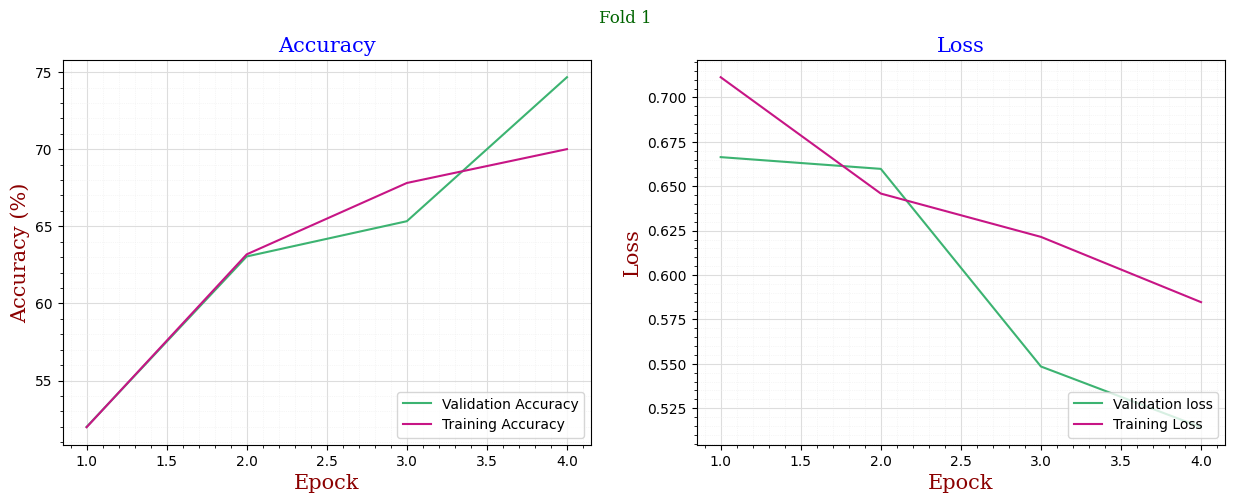

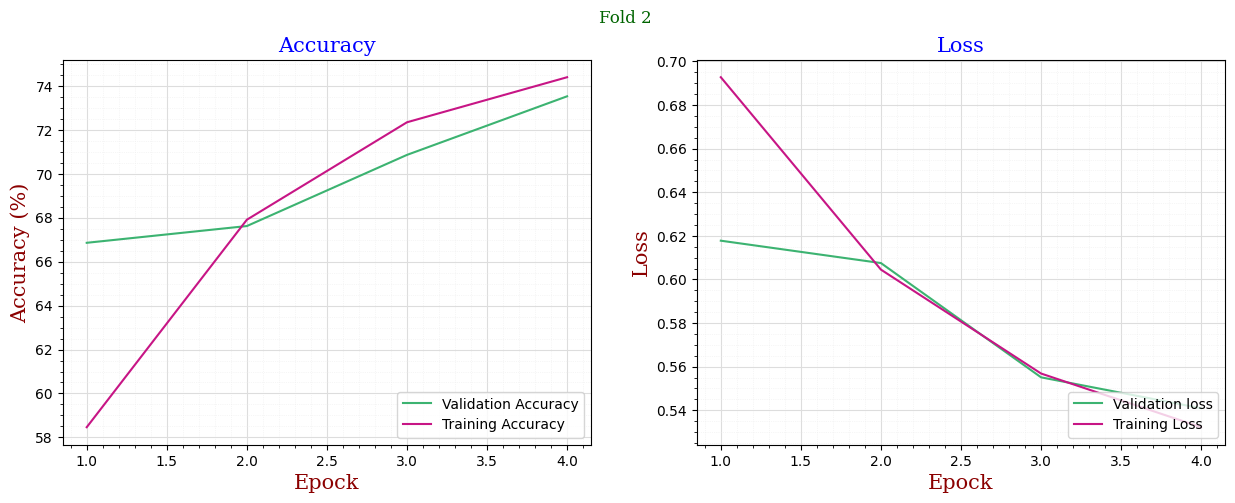

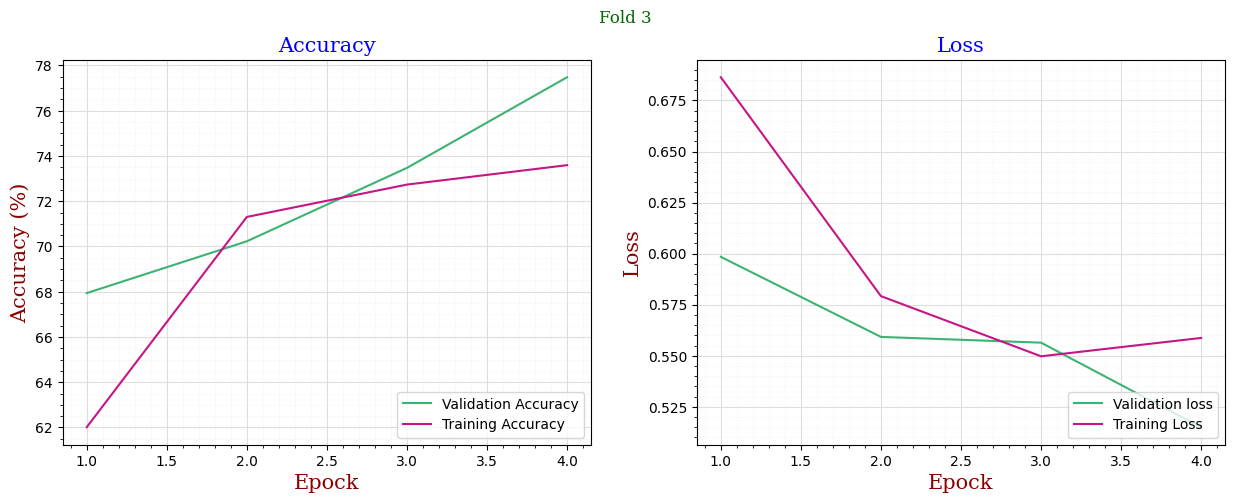

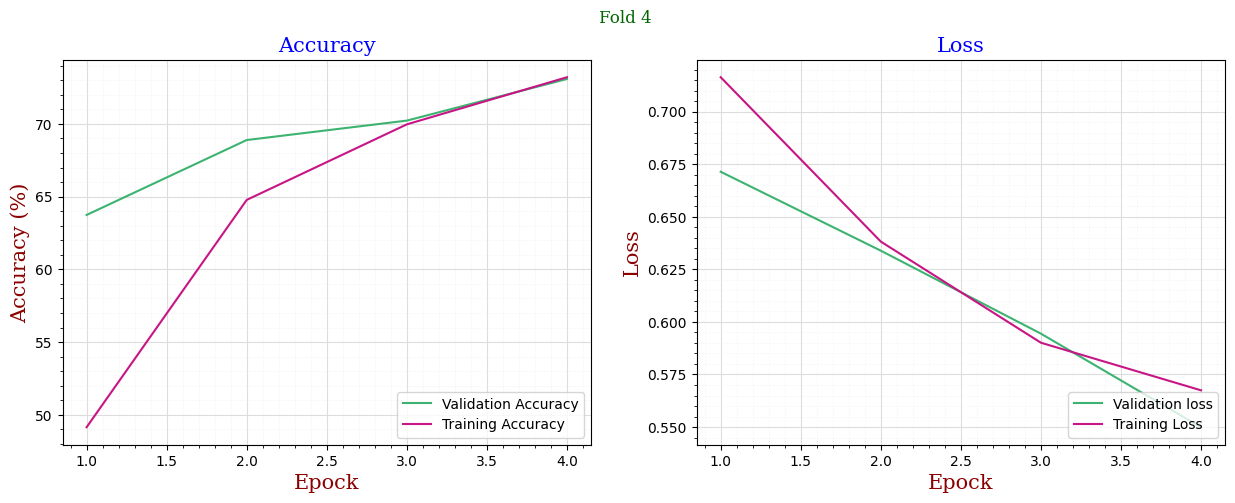

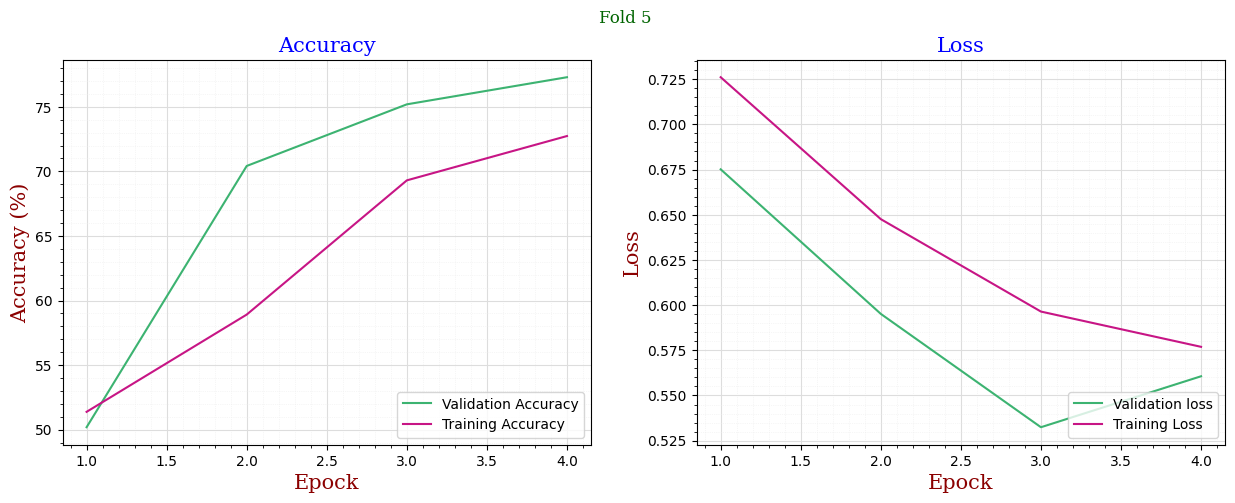

In [23]:
CurvePlotter(validation_accuracy, validation_losses, train_losses, train_accuracy)

Test Loss: 0.4980, Test Accuracy: 76.83%
Precision: 0.7892
Recall: 0.7616
F1-Score: 0.7751
AUC: 0.7686
MCC: 0.5367


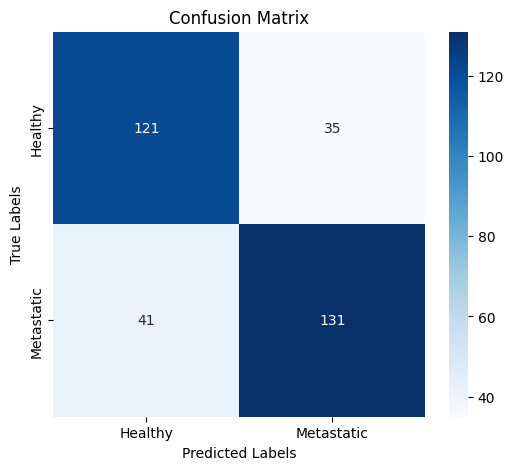

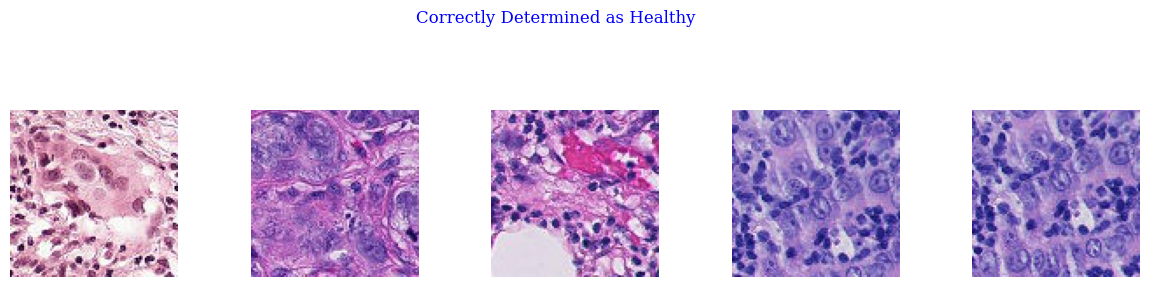

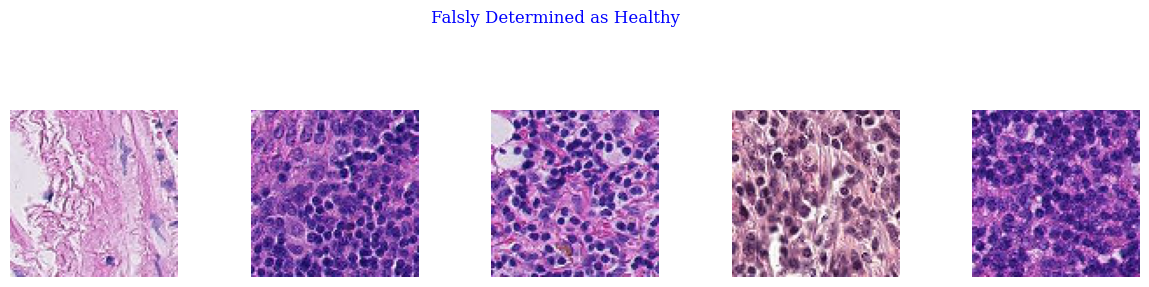

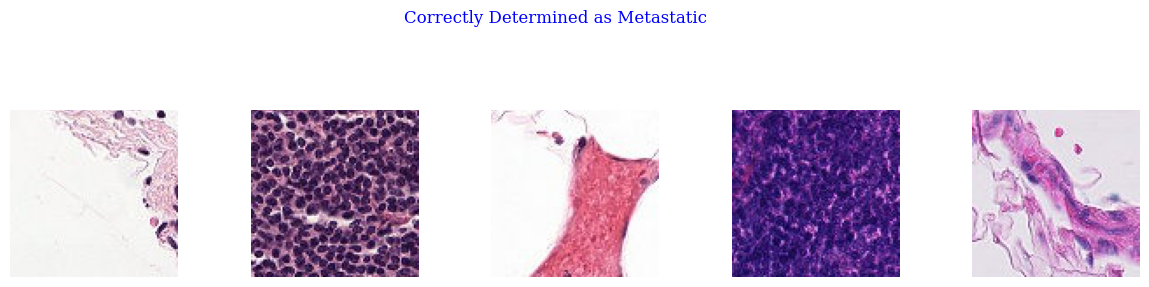

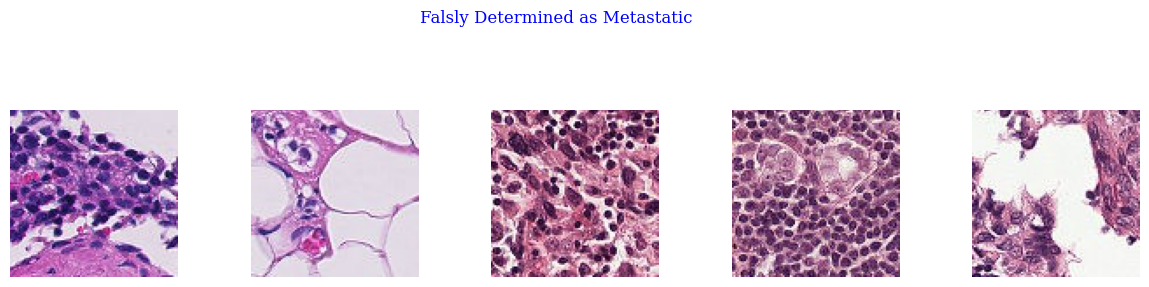

In [24]:
prediction = TestModel(best_model, test_loader, criterion)
CalculateMetrics(test_labels, prediction, test_images)